### Описание задачи

Ссылка - https://semantic-textual-relatedness.github.io/

Задача по автоматическому определению степени сематической связанности между парами предложений. Предложения представлены на различных языках (мы возьмем английский).

Два предложения считаются семантически схожими, когда у них есть парафразное или подразумевающее отношение. С другой стороны, связанность - это гораздо более широкое понятие, которое учитывает все общие черты между двумя предложениями: посвящены ли они одной теме, выражают ли одну и ту же точку зрения, относятся ли к одному и тому же периоду времени, одно развивает другое (или вытекает из него) и т.д. Например, для следующих пар предложений:

| Pairs |                 Sentence 1                 |                   Sentence 2                   |
|:-----:|:------------------------------------------:|:----------------------------------------------:|
|   1   | There was a lemon tree next to the house.  | The boy enjoyed reading under the lemon tree.  |
|   2   |  There was a lemon tree next to the house. |   The boy was an excellent football player.    |

Большинство скажут, что 1-я пара более связана, чем вторая

Нам нужно определить семантическую связанность двух предложений, оценивая это от 0 до 1, где 0 - не связанны вообще, а 1 максимально связанные.


### Данные

Нам даны 2 текстовых признака - предложения и 1 числовой - насколько схожи эти два предложения.

Целевой признак у нас это именно последний. Он может принимать дробное значение от 0 до 1 включительно.

Датасет имеет следующую структуру:
- **PairID** - уникальный id пары предложений
- **Text** - тексты, записанные подряд через '\n'
- **Score** - оценка семантической близости предложений

### Измерение качества

Официальной метрикой оценки для этого задания является коэффициент ранговой корреляции Спирмена, который отражает, насколько хорошо предсказанные системой рейтинги тестовых экземпляров согласуются с суждениями человека. 

Код оценки - https://github.com/semantic-textual-relatedness/Semantic_Relatedness_SemEval2024/blob/main/evaluation_script/evaluation.py

In [13]:
import re

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

import assets

In [14]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('dark')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
train_data = pd.read_csv('eng_train.csv')
train_data.head()

,PairID,Text,Score
0,ENG-train-0000,"It that happens, just pull the plug.\nif that ...",1.0
1,ENG-train-0001,A black dog running through water.\nA black do...,1.0
2,ENG-train-0002,I've been searchingthe entire abbey for you.\n...,1.0
3,ENG-train-0003,If he is good looking and has a good personali...,1.0
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...",1.0


In [16]:
def prepare_table(df: pd.DataFrame):
    temp = df['Text'].apply(lambda x: x.split("\n")).tolist()
    text1 = []
    text2 = []
    for i in temp:
        text1.append(i[0])
        text2.append(i[1])
    df['Text_1'] = text1
    df['Text_2'] = text2
    df = df[['PairID', 'Text_1', 'Text_2', 'Score']]
    return df

In [17]:
# Creating a column "Split_Text" which is a list of two sentences.
train_data = prepare_table(train_data)
train_data.head()

,PairID,Text_1,Text_2,Score
0,ENG-train-0000,"It that happens, just pull the plug.","if that ever happens, just pull the plug.",1.0
1,ENG-train-0001,A black dog running through water.,A black dog is running through some water.,1.0
2,ENG-train-0002,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.,1.0
3,ENG-train-0003,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ...",1.0
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed.",1.0


Для дальнейшей работы лемматизируем предложения и удалим стоп слова.

In [18]:
train_data['Text_1_lemmas'] = assets.lemmatize_texts(train_data['Text_1'])
train_data['Text_2_lemmas'] = assets.lemmatize_texts(train_data['Text_2'])
train_data.head()

100%|██████████| 5500/5500 [00:03<00:00, 1691.05it/s]


,PairID,Text_1,Text_2,Score,Text_1_lemmas,Text_2_lemmas
0,ENG-train-0000,"It that happens, just pull the plug.","if that ever happens, just pull the plug.",1.0,happens pull plug,ever happens pull plug
1,ENG-train-0001,A black dog running through water.,A black dog is running through some water.,1.0,black dog run water,black dog run water
2,ENG-train-0002,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.,1.0,searchingthe entire abbey,look abbey
3,ENG-train-0003,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ...",1.0,good look good personality might straight like...,good look good personality might straight like...
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed.",1.0,hate annoyed,hate annoyed


### Эксплоративный анализ

Для начала посмотрим на распределение скоров по частоте и в зависимости от модуля разности длин пары предложений.

In [19]:
train_data['Text_1_len'] = train_data['Text_1'].apply(len)
train_data['Text_2_len'] = train_data['Text_2'].apply(len)
train_data['len_dif'] = np.fabs(train_data['Text_1_len'] - train_data['Text_2_len'])
train_data.head()

,PairID,Text_1,Text_2,Score,Text_1_lemmas,Text_2_lemmas,Text_1_len,Text_2_len,len_dif
0,ENG-train-0000,"It that happens, just pull the plug.","if that ever happens, just pull the plug.",1.0,happens pull plug,ever happens pull plug,36,41,5.0
1,ENG-train-0001,A black dog running through water.,A black dog is running through some water.,1.0,black dog run water,black dog run water,34,42,8.0
2,ENG-train-0002,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.,1.0,searchingthe entire abbey,look abbey,44,39,5.0
3,ENG-train-0003,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ...",1.0,good look good personality might straight like...,good look good personality might straight like...,101,87,14.0
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed.",1.0,hate annoyed,hate annoyed,52,42,10.0


Проверим на выбросы по длинам.

Text(0.5, 1.0, 'Text 2 length distribution')

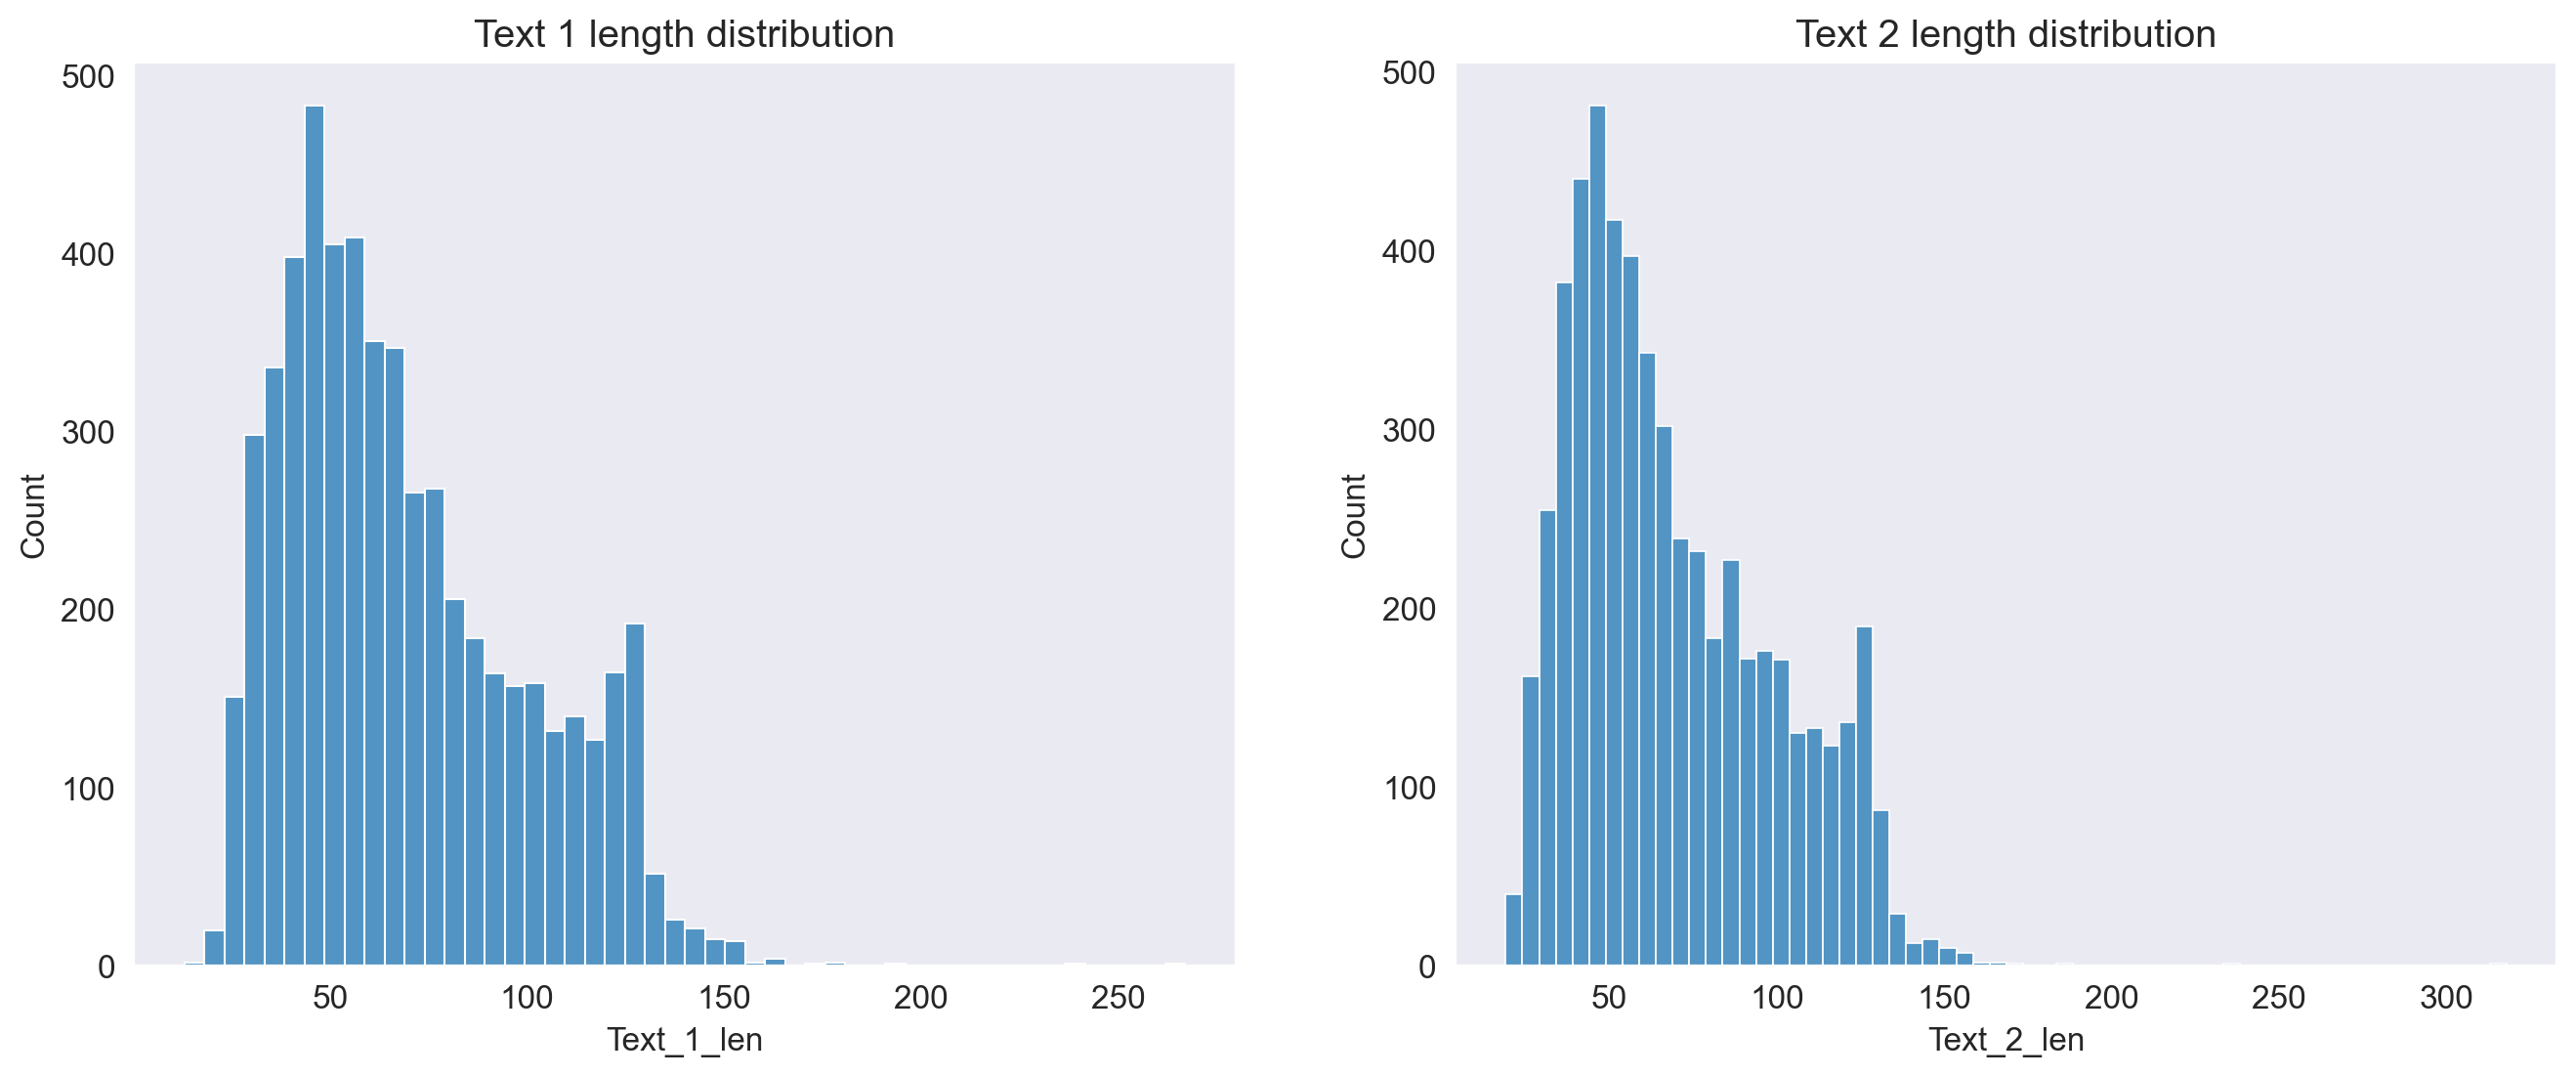

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(x=train_data['Text_1_len'], ax=axs[0])
axs[0].set_title('Text 1 length distribution')

sns.histplot(x=train_data['Text_2_len'], ax=axs[1])
axs[1].set_title('Text 2 length distribution')

Явных выбросов нету, но для более устойчивого обучения следует сделать ограничение по длине на 170 слов.

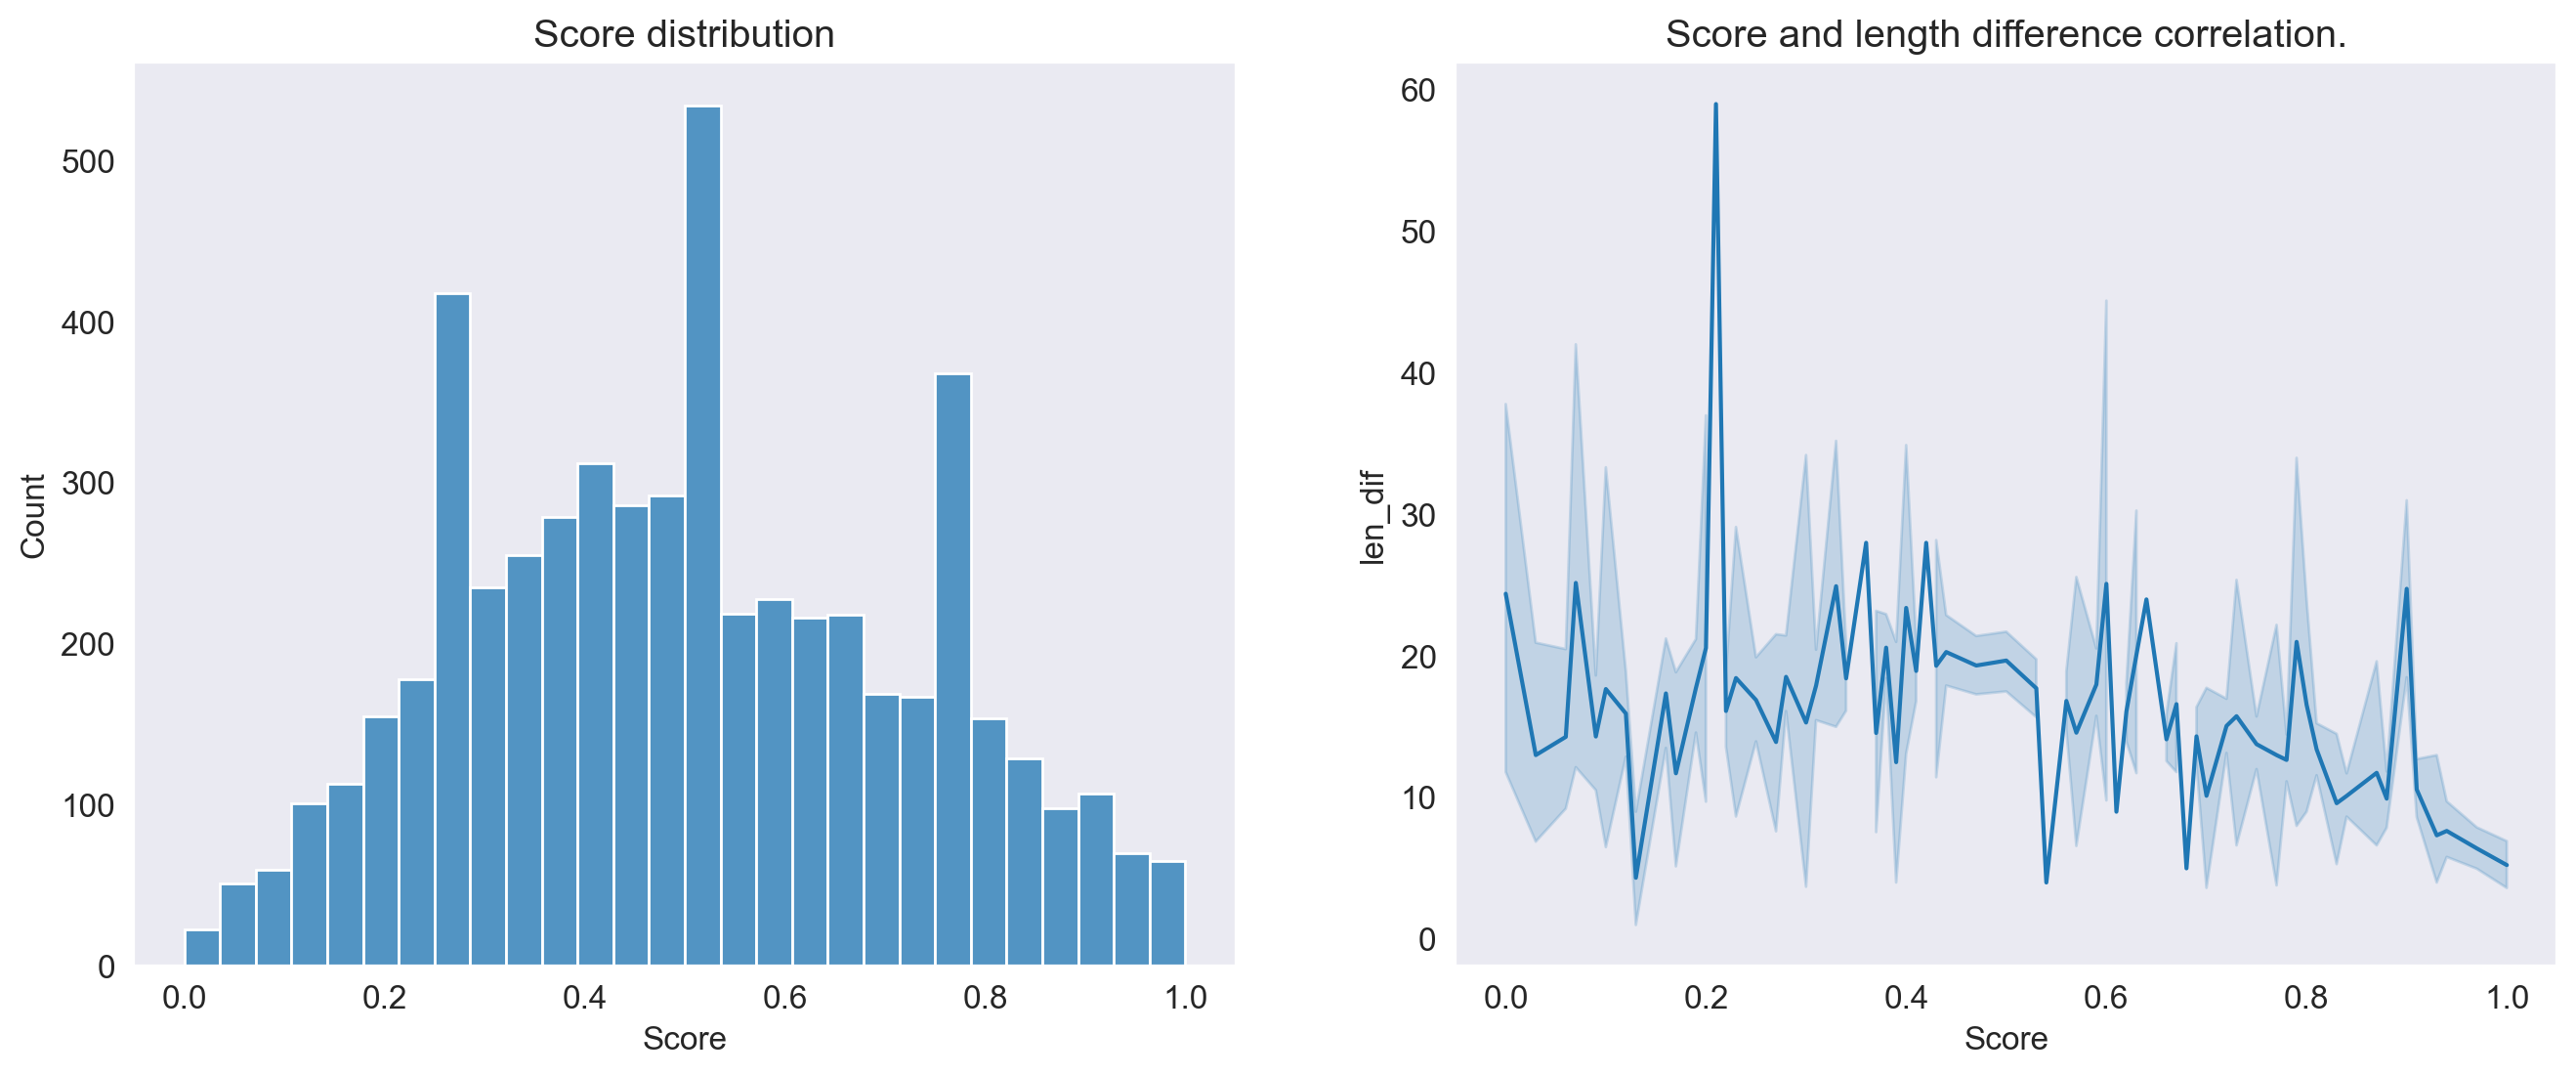

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(x=train_data['Score'], ax=axs[0])
axs[0].set_title('Score distribution')

sns.lineplot(x=train_data['Score'], y=train_data['len_dif'], ax=axs[1])
axs[1].set_title('Score and length difference correlation.')
plt.savefig('report/images/score_distribution.png', bbox_inches='tight', pad_inches=0);

Распределение по целевой функции немного похоже на нормальное с сильным отрывом 0.5 от остальных значений. 

Также видим, что скор обратно пропорционален разности длин текстов, что соответствует интуиции: длинные предложения обычно имеют смысл отличные от коротких.

Дополнительно взглянем на близости текстов в датасете. В качестве меры близости будем использовать WER на лемматизированных предложениях:
$$ WER = \frac{S + D + I}{N} =  \frac{S + D + I}{S + D + C}$$
где:
- S – количество замен,
- D – количество делеций,
- I — количество вставок,
- C – количество правильных слов,
- N — количество слов в ссылке $(N = S + D + C)$

Рассмотрим распределение WER по частоте и в зависимости от скора.

In [22]:
from editdistance import eval

def calc_wer(target_text: str, predicted_text: str) -> float:
    if not target_text:
        if predicted_text:
            return 1
        return 0
    target_words = target_text.split(' ')
    pred_words = predicted_text.split(' ')
    return eval(target_words, pred_words) / len(target_words)

train_data['WER'] = [calc_wer(text_a, text_b) for text_a, text_b in zip(train_data['Text_1_lemmas'].to_list(), train_data['Text_2_lemmas'].to_list())]

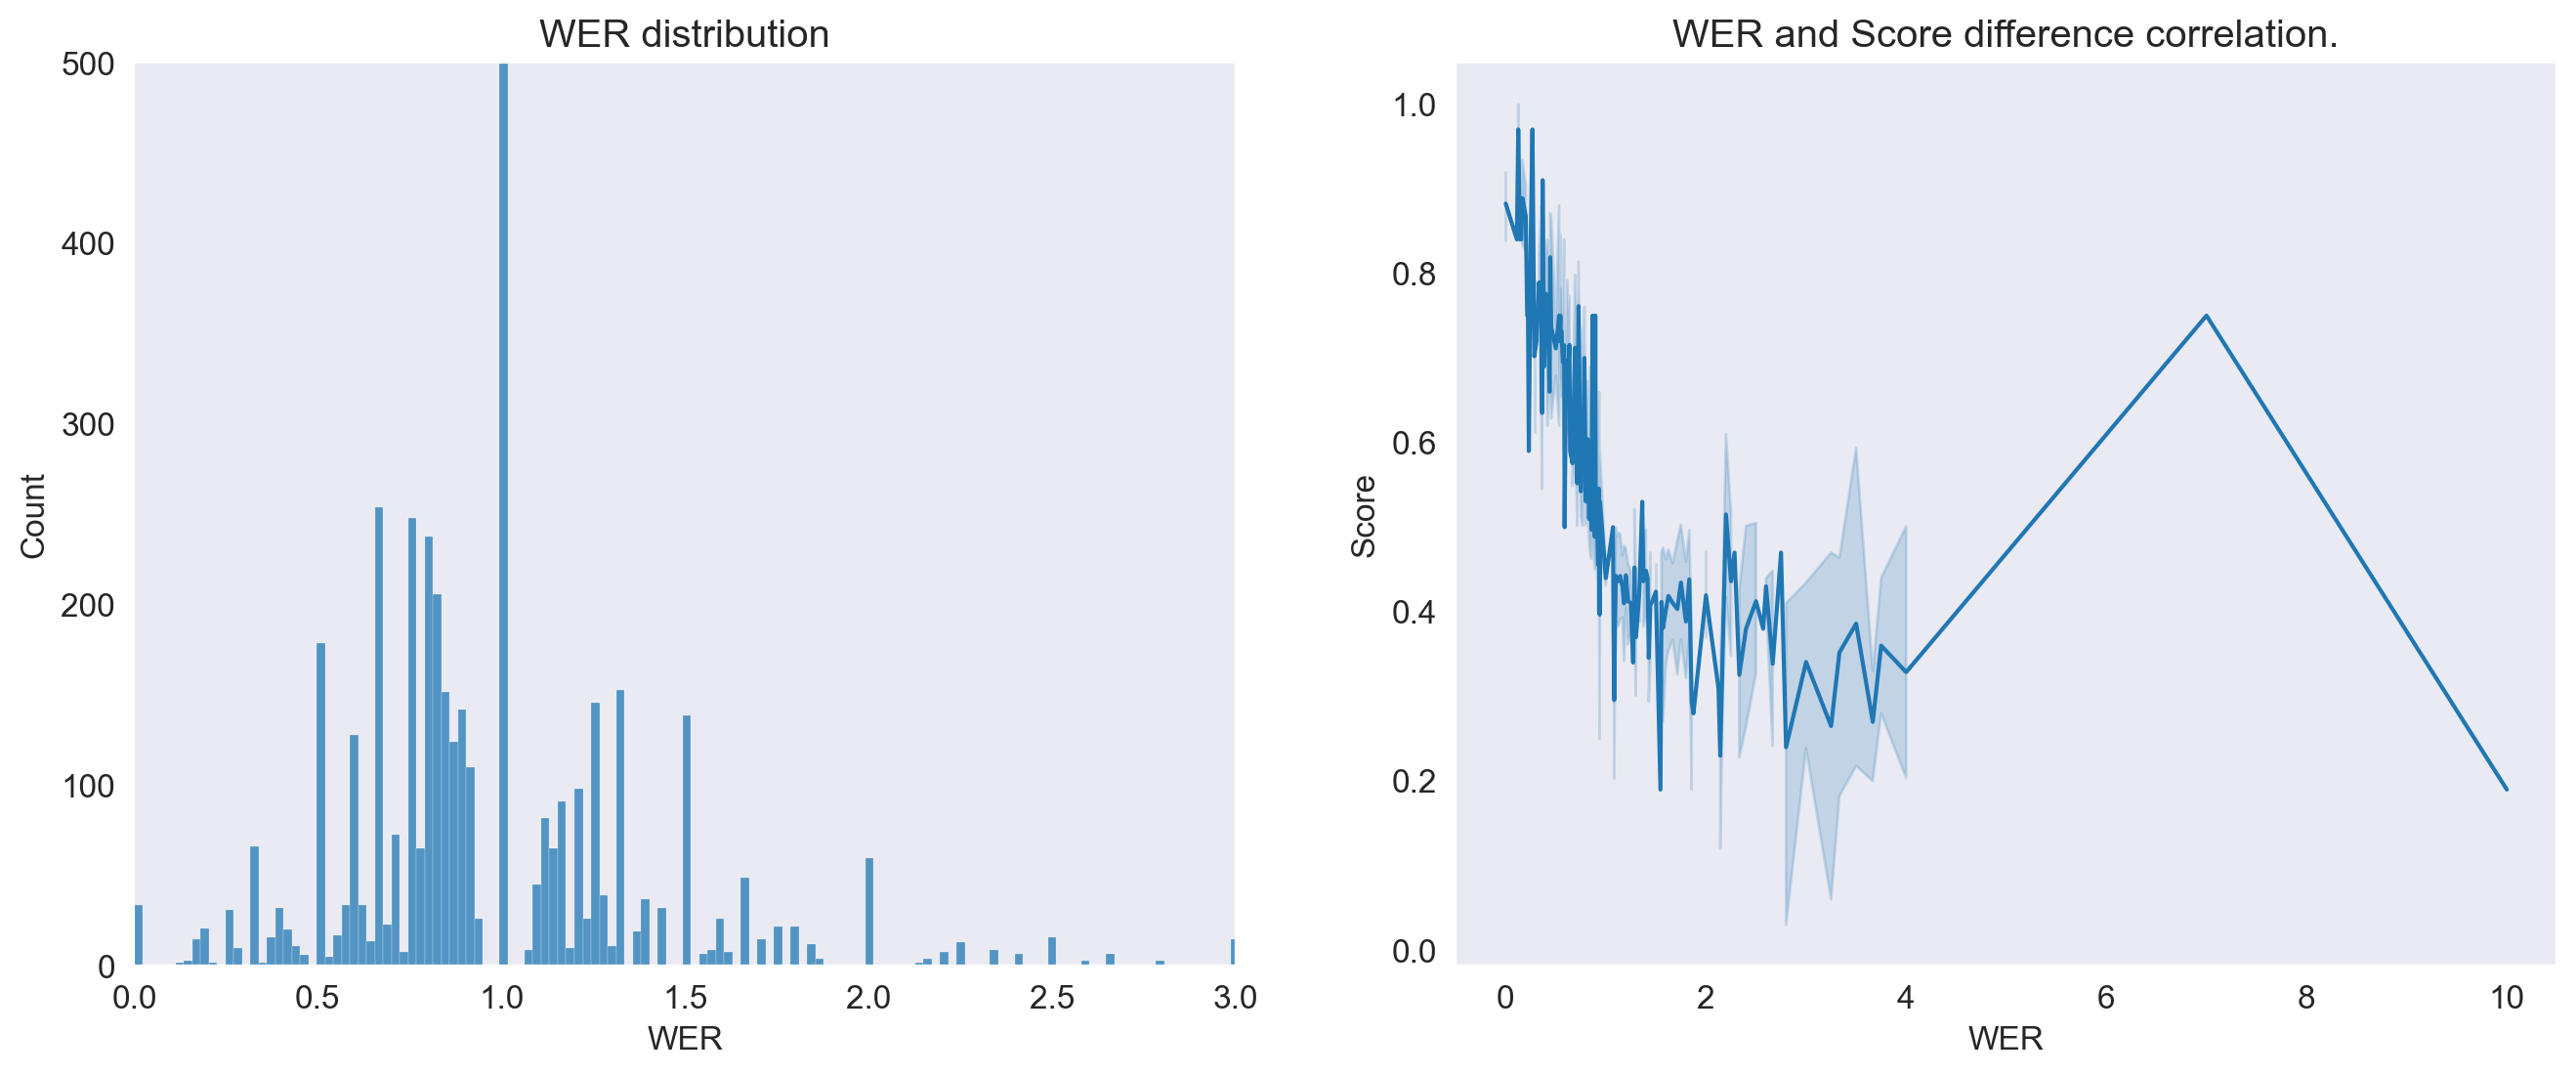

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(x=train_data['WER'], ax=axs[0])
axs[0].set_title('WER distribution')
axs[0].set_xlim([0, 3])
axs[0].set_ylim([0, 500])

sns.lineplot(x=train_data['WER'], y=train_data['Score'], ax=axs[1])
axs[1].set_title('WER and Score difference correlation.')
plt.savefig('report/images/wer_distribution.png', bbox_inches='tight', pad_inches=0);

Мы видим, что на лемматизированных текстах WER в среднем равен 1. Это означает, что пары текстов различны морфологически в основном (то есть наборами, представляющих их слов).

Ожидаемо, чем ниже WER - тем лучше Score.

### Бэйслайн TF-IDF + RandomForestRegressor

В качестве собственного бейслайна мы сконкатенировали предложения, построили на них TF-IDF и обучили RandomForestRegressor на скор.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer as TF_IDF
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

train_data['merged_lemmas'] = [text_a + ' ' + text_b for text_a, text_b in zip(train_data['Text_1_lemmas'].to_list(), train_data['Text_2_lemmas'].to_list())]
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [33]:
tf_idf_model = TF_IDF()

train_X = tf_idf_model.fit_transform(train_data['merged_lemmas'].to_list())
val_X = tf_idf_model.transform(val_data['merged_lemmas'].to_list())

train_y = train_data['Score'].to_numpy()
val_y = val_data['Score'].to_numpy()

In [34]:
model = RandomForestRegressor(n_jobs=-1)

model.fit(train_X, train_y)
pred = model.predict(val_X)

print('MSE:', MSE(val_y, pred))

MSE: 0.04086527947541218
